In [1]:
from qrisp import *
from qrisp.vqe.problems.electronic_structure import *
from pyscf import gto
from qrisp.operators import FermionicOperator

mol = gto.M(atom = '''H 0 0 0; H 0 0 0.74''', basis = 'sto-3g')

H = FermionicOperator.from_pyscf(mol).to_qubit_operator().to_pauli()

data = electronic_data(mol)


In [2]:
N = data["num_orb"]
M = data["num_elec"]

# Hartree-Fock state
def U_0(qv):
    for i in range(M):
        x(qv[i])

def exp_H(qv, t):
    H.trotterization(method='commuting')(qv,t,5)

In [3]:
qv = QuantumVariable(N)
U_0(qv)
E_0 = H.get_measurement(qv)
print(E_0)

-1.8283676247022933                                                                  


In [4]:
import numpy as np
import sympy as sp
from qrisp.qite import QITE

steps = 3
s_values = np.linspace(.01,1.0,10)

theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = [E_0]

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(N)
    QITE(qv, U_0, exp_H, optimal_s, k, method='GC')
    qc = qv.qs.compile()

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting',precision=0.001) for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])

print(optimal_energies)

[-1.8391470251758661, -1.8504258296205625, -1.8528313078714373, -1.8525108075314747] 


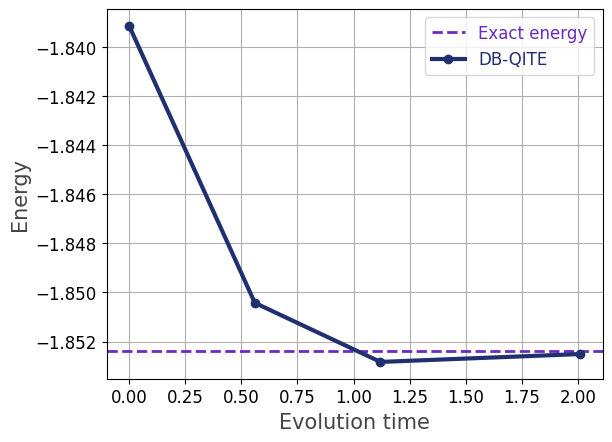

In [5]:
import matplotlib.pyplot as plt

evolution_times = [sum(optimal_s[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=H.ground_state_energy(), color='#6929C4', linestyle='--', linewidth=2, label='Exact energy')
plt.plot(evolution_times, optimal_energies, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.show()

In [6]:
import numpy as np
import sympy as sp
from qrisp.qite import QITE

steps = 2
s_values = np.linspace(.01,1.0,10)

theta = sp.Symbol('theta')
optimal_s = [theta]
optimal_energies = [E_0]

for k in range(1,steps+1):

    # Perform k steps of QITE
    qv = QuantumVariable(N)
    QITE(qv, U_0, exp_H, optimal_s, k, method='HOPF')
    qc = qv.qs.compile()

    # Find optimal evolution time 
    # Use "precompliled_qc" keyword argument to avoid repeated compilation of the QITE circuit
    energies = [H.get_measurement(qv,subs_dic={theta:s_},precompiled_qc=qc,diagonalisation_method='commuting',precision=0.001) for s_ in s_values]
    index = np.argmin(energies)
    s_min = s_values[index]

    optimal_s.insert(-1,s_min)
    optimal_energies.append(energies[index])

print(optimal_energies)

[-1.8391470251758661, -1.85312159113732, -1.8530539270764526]                        


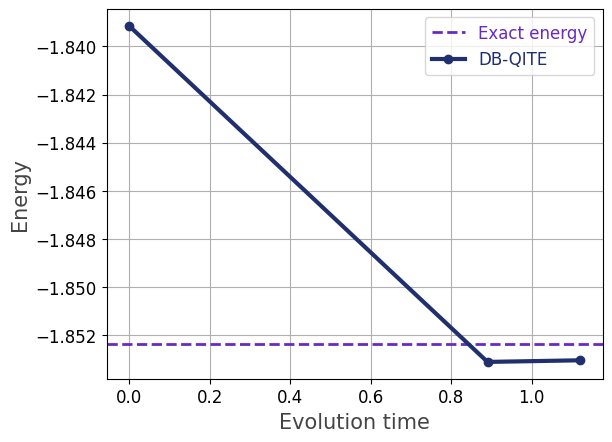

In [7]:
import matplotlib.pyplot as plt

evolution_times = [sum(optimal_s[i] for i in range(k)) for k in range(steps+1)]

plt.xlabel('Evolution time', fontsize=15, color='#444444')
plt.ylabel('Energy', fontsize=15, color='#444444')
plt.axhline(y=H.ground_state_energy(), color='#6929C4', linestyle='--', linewidth=2, label='Exact energy')
plt.plot(evolution_times, optimal_energies, c='#20306f', marker="o", linestyle='solid', linewidth=3, zorder=3, label='DB-QITE')
plt.legend(fontsize=12, labelcolor='linecolor')
plt.tick_params(axis='both', labelsize=12)
plt.grid()
plt.show()